<a href="https://colab.research.google.com/github/MohsenJadidi/Erdos-Goes-Neural/blob/main/ModifiedCode/Clique_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install package

In [ ]:
# !pip install torch_scatter==latest+cu101 torch_sparse==latest+cu101
# !pip install torch_geometric


In [1]:
!pip install torch_scatter
!pip install torch_sparse
!pip install torch_geometric


In [2]:
!apt-get install python3-dev graphviz libgraphviz-dev pkg-config
!pip install graphviz
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
libgraphviz-dev is already the newest version (2.40.1-2).
python3-dev is already the newest version (3.6.7-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [3]:
!pip install visdom
!pip install GPUtil

In [4]:
import visdom 
from visdom import Visdom 
import numpy as np
import matplotlib.pyplot as plt

def plot_grad_flow( named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.yscale('log')
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    

class VisdomLinePlotter(object):
    """Plots to Visdom"""
    def __init__(self, env_name='main'):
        self.viz = Visdom(port=8097)
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y):
        if title_name not in self.plots:
            self.plots[title_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel='Epochs',
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[title_name], name=split_name, update = 'append')
    

    def histog(self,title_name,vals):
        if title_name not in self.plots:
            self.plots[title_name] = self.viz.histogram(X=vals,env=self.env,opts=dict(title=title_name,numbins=20))
        else:
            self.viz.histogram(X=vals,env=self.env,win=self.plots[title_name],opts=dict(title=title_name,numbins=20, update = 'replace'))
  
    def gradflow(self, model, title_name):
                    title_name = "Gradflow"
                    layers = []
                    ave_grads = []
                    for n, p in net.named_parameters():
                            if(p.requires_grad) and ("bias" not in n):
                                     layers.append(str(n))
                                     ave_grads.append(p.grad.abs().mean().cpu().numpy())
                    if title_name not in self.plots:
                        self.plots[title_name]= self.viz.line(X= list(range(len(layers))),Y= np.array(ave_grads),  env = self.env,  opts=dict(fillarea=True, title = title_name, xtick = True,
        xtickmin=0, xtickmax=len(layers), xtickvals = list(range(len(layers))), xtickstep=1/len(layers), xticklabels = layers) )    
                    else:
                        self.viz.line(X= list(range(len(layers))), Y=ave_grads, env = self.env ,win=self.plots[title_name], opts=dict(fillarea=True, title = title_name, xtick = True,
        xtickmin=0, xtickmax=len(layers), xtickvals = list(range(len(layers))), xtickstep=1/len(layers), xticklabels = layers, update="append"))

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('/content/drive/My Drive/ISLR Course - Fall 2020/Project')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Import

In [6]:
import os
import pickle
import torch
import torch.nn.functional as F
from torch.nn import Linear
#from kernel.datasets import get_dataset
import time
from torch import tensor
from torch.optim import Adam
from torch.optim import SGD
from torch_geometric.data import DataLoader, DenseDataLoader as DenseLoader
from math import ceil
from torch.nn import Linear
from torch.distributions import categorical
from torch.distributions import Bernoulli
import torch.nn
%matplotlib inline
from matplotlib import pyplot as plt
import pygraphviz as pgv
from torch_geometric.utils import convert as cnv
from torch_geometric.utils import sparse as sp
from torch_geometric.data import Data
import pygraphviz as pgv
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
from torch.utils.data.sampler import RandomSampler
from torch.nn.functional import gumbel_softmax
from torch.distributions import relaxed_categorical
from torch_geometric.nn.inits import uniform
from torch_geometric.nn.inits import glorot, zeros
from torch.nn import Parameter
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree
from torch_geometric.nn import GINConv, GATConv
from torch.nn import Parameter
from torch.nn import Sequential as Seq, Linear, ReLU, LeakyReLU
from torch_geometric.nn import MessagePassing
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN
#from torch_geometric.utils import scatter_
from torch_geometric.data import Batch 
from torch_scatter import scatter_min, scatter_max, scatter_add, scatter_mean
from torch import autograd
from torch_geometric.utils import softmax, add_self_loops, remove_self_loops, segregate_self_loops, remove_isolated_nodes, contains_isolated_nodes, add_remaining_self_loops
from models import clique_MPNN, cut_MPNN
from modules_and_utils import derandomize_cut, GATAConv,get_diracs, derandomize_clique_final, derandomize_clique_final_speed, solve_gurobi_maxclique
from torch_geometric.utils import to_networkx #+++++++++++++++++
import networkx as nx #+++++++++++++++++
import scipy
import scipy.io
import GPUtil
import numpy as np
from networkx.algorithms.approximation import max_clique
from torch_geometric.data import DataListLoader
from random import shuffle
from networkx.algorithms.approximation import max_clique
from networkx.algorithms import graph_clique_number
from networkx.algorithms import find_cliques

# Read Dataset

In [ ]:

# datasets = ["TWITTER_SNAP", "COLLAB", "IMDB-BINARY"]
# dataset_name = datasets[2]
# path_to_dataset ="%PATH"
# if dataset_name == "TWITTER_SNAP":
#     stored_dataset = open(path_to_dataset, 'rb')        
# elif dataset_name == "COLLAB":
#     stored_dataset = open(path_to_dataset, 'rb')
# elif dataset_name == "IMDB-BINARY":
#     stored_dataset = open(path_to_dataset, 'rb')

address = '/content/drive/My Drive/ISLR Course - Fall 2020/Project/IMDB_BINARY.p'
stored_dataset = open(address, 'rb')      

dataset = pickle.load(stored_dataset)
dataset_scale = 1
# total_samples = int(np.floor(len(dataset)*dataset_scale))
total_samples = int(np.floor(dataset.len()*dataset_scale))

dataset = dataset[:total_samples]

# num_trainpoints = int(np.floor(0.6*len(dataset)))
# num_valpoints = int(np.floor(num_trainpoints/3))
# num_testpoints = len(dataset) - (num_trainpoints + num_valpoints)
# traindata= dataset[0:num_trainpoints]
# valdata = dataset[num_trainpoints:num_trainpoints + num_valpoints]
# testdata = dataset[num_trainpoints + num_valpoints:]
# batch_size = 32
# train_loader = DataLoader(traindata, batch_size, shuffle=True)
# test_loader = DataLoader(testdata, batch_size, shuffle=False)
# val_loader =  DataLoader(valdata, batch_size, shuffle=False)

# #set up random seeds 
# torch.manual_seed(1)
# np.random.seed(2)   
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

AttributeError: ignored

In [ ]:
#type(dataset)

print(dataset.get(999))
type(dataset.get(999))


In [ ]:
print(dataset.data)
type(dataset.data)

In [ ]:
dataset.slices

## Test other dataset

In [ ]:
!pip install spektral

In [ ]:
from spektral.datasets import TUDataset
import numpy as np
from spektral.data import BatchLoader

dataset = TUDataset('PROTEINS')
dataset_scale = 1
total_samples = int(np.floor(len(dataset)*dataset_scale))

dataset_name = 'PROTEINS'

dataset = dataset[:total_samples]
num_trainpoints = int(np.floor(0.6*len(dataset)))
num_valpoints = int(np.floor(num_trainpoints/3))
num_testpoints = len(dataset) - (num_trainpoints + num_valpoints)
traindata= dataset[0:num_trainpoints]
valdata = dataset[num_trainpoints:num_trainpoints + num_valpoints]
testdata = dataset[num_trainpoints + num_valpoints:]
batch_size = 32
#train_loader = DataLoader(traindata, batch_size, shuffle=True)
#test_loader = DataLoader(testdata, batch_size, shuffle=False)
#val_loader =  DataLoader(valdata, batch_size, shuffle=False)
train_loader = BatchLoader(traindata, batch_size, shuffle=True)
test_loader = BatchLoader(testdata, batch_size, shuffle=False)
val_loader =  BatchLoader(valdata, batch_size, shuffle=False)

#set up random seeds 
torch.manual_seed(1)
np.random.seed(2)   
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

ModuleNotFoundError: ignored

## Another dataset

In [7]:
from torch_geometric.datasets import TUDataset
import numpy as np

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset_name = "ENZYMES"

dataset_scale = 1
total_samples = int(np.floor(len(dataset)*dataset_scale))
dataset = dataset[:total_samples]

num_trainpoints = int(np.floor(0.6*len(dataset)))
num_valpoints = int(np.floor(num_trainpoints/3))
num_testpoints = len(dataset) - (num_trainpoints + num_valpoints)

traindata= dataset[0:num_trainpoints]
valdata = dataset[num_trainpoints:num_trainpoints + num_valpoints]
testdata = dataset[num_trainpoints + num_valpoints:]

batch_size = 32

train_loader = DataLoader(traindata, batch_size, shuffle=True)
test_loader = DataLoader(testdata, batch_size, shuffle=False)
val_loader =  DataLoader(valdata, batch_size, shuffle=False)


#set up random seeds 
torch.manual_seed(1)
np.random.seed(2)   
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
print(dataset[0]['edge_index'])

tensor([[ 0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12,
         12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16,
         16, 16, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 20, 20,
         21, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25,
         25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28,
         28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 32,
         32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35,
         35, 35, 36, 36, 36, 36],
        [ 1,  2,  3,  0,  2,  3, 24, 27,  0,  1,  3, 27, 28,  0,  1,  2,  4,  5,
         28,  3,  5,  6, 29,  3,  4,  6,  7, 29,  4,  5,  7,  8,  5,  6,  8,  9,
         10,  6,  7,  9,  7,  8, 10, 11, 12,  7,  9, 11, 12,  9, 10, 12, 26

[(0, 1), (0, 2), (0, 3), (0, 0), (0, 2), (0, 3), (0, 24), (0, 27), (0, 0), (0, 1), (0, 3), (0, 27), (0, 28), (0, 0), (0, 1), (0, 2), (0, 4), (0, 5), (0, 28), (0, 3), (0, 5), (0, 6), (0, 29), (0, 3), (0, 4), (0, 6), (0, 7), (0, 29), (0, 4), (0, 5), (0, 7), (0, 8), (0, 5), (0, 6), (0, 8), (0, 9), (0, 10), (0, 6), (0, 7), (0, 9), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 7), (0, 9), (0, 11), (0, 12), (0, 9), (0, 10), (0, 12), (0, 26), (0, 9), (0, 10), (0, 11), (0, 25), (0, 26), (0, 14), (0, 15), (0, 16), (0, 25), (0, 13), (0, 15), (0, 16), (0, 25), (0, 13), (0, 14), (0, 16), (0, 17), (0, 13), (0, 14), (0, 15), (0, 17), (0, 15), (0, 16), (0, 18), (0, 19), (0, 17), (0, 19), (0, 20), (0, 17), (0, 18), (0, 20), (0, 18), (0, 19), (0, 21), (0, 22), (0, 23), (0, 30), (0, 20), (0, 22), (0, 23), (0, 30), (0, 35), (0, 20), (0, 21), (0, 23), (0, 35), (0, 20), (0, 21), (0, 22), (0, 33), (0, 1), (0, 27), (0, 28), (0, 29), (0, 12), (0, 13), (0, 14), (0, 26), (0, 29), (0, 11), (0, 12), (0, 25), (0,

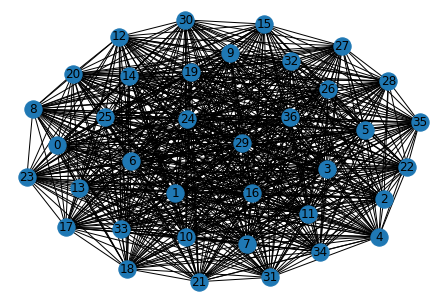

In [ ]:
source = dataset[0]['edge_index'][0]
target = dataset[0]['edge_index'][1]

source = source.tolist()
target = target.tolist()

edge_list = []
for i in source:
  for j in target:
    edge_list.append((i,j))

print(edge_list)    
H = nx.Graph(edge_list)
nx.draw(H, with_labels=True)

# Train

In [8]:
def predict(model, data_loader, recfield):
    model.train()
    avg_loss = 0
    avg_cliqdist = 0
    exp_cardinalities = torch.tensor(0)
    for data in data_loader:
        optimizer.zero_grad()
        #data = data.to(device) #+-+-+-+-+-+-+-+-+
        data = get_diracs(data, 1, sparse = True, effective_volume_range=0.15, receptive_field = recfield)
        #data = data.to(device) #+-+-+-+-+-+-+-+-+
        retdict = model(data)
        avg_loss += retdict['loss'][0].item()/len(data_loader)
        avg_cliqdist += retdict["Currvol/Cliquevol"][0].item()/len(data_loader)
        exp_cardinalities = [retdict["Expected_cardinality_hist"][0]]
    return avg_loss, avg_cliqdist, exp_cardinalities

In [9]:
from models import clique_MPNN, cut_MPNN

net =  clique_MPNN(dataset,4, 64, 1 ,1, elasticity = None)

In [30]:
from itertools import product

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr_decay_step_size = 5
lr_decay_factor = 0.95

b_sizes = [32]
l_rates = [0.001]
depths = [4]
coefficients = [4.]
rand_seeds = [66]
widths = [64]
epochs = 100
net.train()
retdict = {}
edge_drop_p = 0.0
edge_dropout_decay = 0.90
penalty_coeff = 9.00
penalty_increase = -0.00
validation_timeout = 75

#save_path = "%PATH"

i = 0
lossList = [] #+++++++++++++++++++++++++++++++++++++++++
outputdic = {}
ExpectedCardinalityList = []

for batch_size, learning_rate, numlayers, penalty_coeff, r_seed, hidden_1 in product(b_sizes, l_rates, depths, coefficients, rand_seeds, widths):
   
    torch.manual_seed(r_seed)
    train_loader = DataLoader(traindata, batch_size, shuffle=True)
    test_loader = DataLoader(testdata, batch_size, shuffle=False)
    val_loader =  DataLoader(valdata, batch_size, shuffle=False)

    receptive_field= numlayers + 1
    val_losses = []
    cliq_dists = []

    hidden_2 = 1

    net =  clique_MPNN(dataset,numlayers, hidden_1, hidden_2 ,1, elasticity = None)
    net.to(device).reset_parameters()
    optimizer = Adam(net.parameters(), lr=learning_rate, weight_decay=0.00000)
    
    envname = "February" + str(net)+ 'PROTOTYPING_' + dataset_name + '_seed: '+ str(r_seed) +"_width1: "+ str(hidden_1) + "_batch size : " + str(batch_size) + "Finalize_Samples_new_code_GCAT" + "_LR: " +str(learning_rate) + "_PenaltyCoeff:  "+ str(penalty_coeff)+ "_Layers: "+ str(numlayers)

    #plotter = VisdomLinePlotter(env_name=envname)
    for epoch in range(epochs):
        totalretdict = {}
        count=0
        if epoch % 5 == 0:
            edge_drop_p = edge_drop_p*edge_dropout_decay
            print("Edge_dropout: ", edge_drop_p)

        if epoch % 10 == 0:
            penalty_coeff = penalty_coeff + 0.
            print("Penalty_coefficient: ", penalty_coeff)
#-----------------------------------
        # if epoch % 15 == 0:
        #     val_l, cliq_dist, val_cardinalities= predict(net, val_loader, receptive_field)
        #     val_losses += [val_l]
        #     cliq_dists += [cliq_dist]
        #     if epoch>30:
        #         if (val_losses[-1] > val_losses[-2]) and (val_losses[-1] > val_losses[-3]) and (epoch>validation_timeout):
        #             print("Converged!")
        #             if val_losses[-2] < val_losses[-3]:
        #                 print("Best model epoch: ", epoch-15)
        #                 #file_name = save_path+ str(dataset_name)+ '/' + str(net)+ '_'+ str(epoch-15)+'_samples.pt'
        #                 #net.load_state_dict(torch.load(file_name), strict=False)
        #             else:
        #                 print("Best model epoch: ", epoch-30)
        #                 #file_name = save_path+ str(dataset_name)+ '/' + str(net)+ '_'+ str(epoch-30)+'_samples.pt'
        #                 #net.load_state_dict(torch.load(file_name), strict=False)
        #             break
        #         if epoch%15==0:
        #             #file_name = save_path+ str(dataset_name)+ '/' + str(net)+ '_'+ str(epoch)+'_samples.pt'
        #             print("file_name: ", file_name)
        #             #torch.save({file_name : net.state_dict()},  file_name)

        print('Here')
        if (epoch % lr_decay_step_size) == 0:
            for param_group in optimizer.param_groups:
                        param_group['lr'] = lr_decay_factor * param_group['lr']
        

        #show currrent epoch and GPU utilizationss
        print('Epoch: ', epoch)
        GPUtil.showUtilization()
        
        
        net.train()
        

        for data in train_loader:
            count += 1 
            optimizer.zero_grad(), 
            data = data.to(device)
            data_prime = get_diracs(data, 1, sparse = True, effective_volume_range=0.15, receptive_field = receptive_field)

            data = data.to('cpu')
            data_prime = data_prime.to(device)

            retdict = net(data_prime, edge_drop_p, penalty_coeff) # In this line, actually forward method runs
            
            for key,val in retdict.items():
                if "sequence" in val[1]:
                    if key in totalretdict:
                        totalretdict[key][0] += val[0].item()
                    else:
                        totalretdict[key] = [val[0].item(),val[1]]

                elif count == 1 and "hist" in val[1]: 
                    try:
                        # plotter.histog(key, val[0].reshape(-1)) #----------------------------
                        pass
                    except:    
                        print(f"Remember, you need more than 1 value for a histogram! Key: {key}", val[0].shape)

                #+++++++++++++++++++++++++++++++++++++++++
                if key == 'loss':
                  lossList.append(val[0].cpu().detach().numpy())

                elif key == 'output' and count == 1:
                  outputdic[i] = (val[0].cpu().detach().numpy())
                  i = i + 1

                elif key == 'Expected_cardinality':
                  ExpectedCardinalityList.append(val[0].cpu().detach().numpy())
                #+++++++++++++++++++++++++++++++++++++++++
            #print("here4")

            if epoch > 2:
              #       print("pre backward------------------------")
#                     #reporter.report()
#                     print("after backward----------------------")
                    retdict["loss"][0].backward()


                    torch.nn.utils.clip_grad_norm_(net.parameters(),1)
                    optimizer.step()
                    del(retdict)
                    if count==1:
                          # plotter.gradflow(net, "Gradflow") #------------
                          pass

        if epoch > -1:        
            for key,val in totalretdict.items():
                if "sequence" in val[1]:
                    val[0] = val[0]/(len(train_loader.dataset)/batch_size)
                    # plotter.plot(key, key, key, epoch, val[0]) #-----------------
                    pass

            del data_prime

Edge_dropout:  0.0
Penalty_coefficient:  4.0
Here
Epoch:  0
| ID | GPU | MEM |
------------------
|  0 |  0% |  9% |
HHHHHHHHHH
torch.Size([1069, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([972, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([976, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([1099, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([669, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([1105, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([1145, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([911, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([1096, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([1654, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([927, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([252, 1])
HHHHHHHHHH
Here
Epoch:  1
| ID | GPU | MEM |
------------------
|  0 | 29% |  9% |
HHHHHHHHHH
torch.Size([1069, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([972, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([976, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([1099, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([669, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([1105, 1])
HHHHHHHHHH
HHHHHHHHHH
torch.Size([1145,

(3.0, 1121.4)

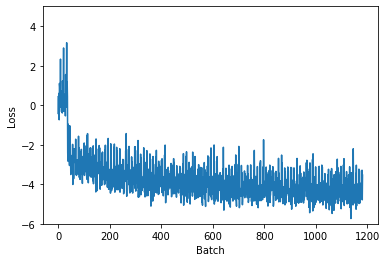

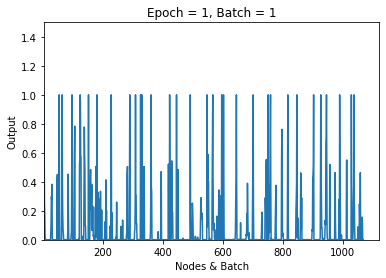

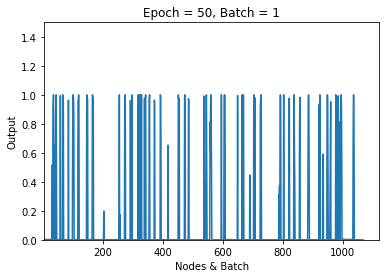

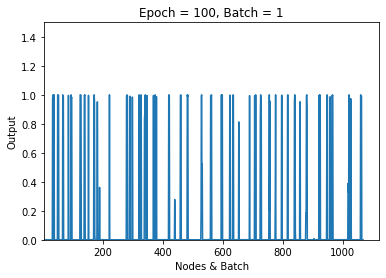

In [71]:
import matplotlib.pyplot as plt
fig = plt.figure()
lossList = list(np.delete(lossList, np.where(np.array(lossList) > 5))) # remove out
plt.plot(lossList)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.ylim((-6,5))

fig = plt.figure()
plt.plot(outputdic[0])
plt.xlabel("Nodes & Batch")
plt.ylabel("Output")
plt.title('Epoch = {e}, Batch = 1'.format(e=1))
plt.ylim((-0,1.5))
plt.xlim(left=3)

fig = plt.figure()
plt.plot(outputdic[49])
plt.xlabel("Nodes & Batch")
plt.ylabel("Output")
plt.title('Epoch = {e}, Batch = 1'.format(e=50))
plt.ylim((-0,1.5))
plt.xlim(left=3)

fig = plt.figure()
plt.plot(outputdic[99])
plt.xlabel("Nodes & Batch")
plt.ylabel("Output")
plt.title('Epoch = {e}, Batch = 1'.format(e=100))
plt.ylim((-0,1.5))
plt.xlim(left=3)

# fig = plt.figure()
# plt.plot(ExpectedCardinalityList)
# plt.xlabel("Batch")
# plt.ylabel("Expected Cardinality")
# # plt.ylim((-6,6))


In [67]:
ExpectedCardinalityList

[array(3.0849807, dtype=float32),
 array(2.890593, dtype=float32),
 array(2.9830618, dtype=float32),
 array(3.00978, dtype=float32),
 array(2.5095627, dtype=float32),
 array(3.0893178, dtype=float32),
 array(3.1623743, dtype=float32),
 array(2.8540983, dtype=float32),
 array(3.138238, dtype=float32),
 array(3.4219663, dtype=float32),
 array(2.924068, dtype=float32),
 array(2.8299088, dtype=float32),
 array(3.0724506, dtype=float32),
 array(2.8817973, dtype=float32),
 array(3.0113618, dtype=float32),
 array(3.1461587, dtype=float32),
 array(2.5326993, dtype=float32),
 array(3.0242796, dtype=float32),
 array(3.1392455, dtype=float32),
 array(3.0251975, dtype=float32),
 array(3.1877854, dtype=float32),
 array(3.6405563, dtype=float32),
 array(2.8614204, dtype=float32),
 array(2.8640585, dtype=float32),
 array(3.0017662, dtype=float32),
 array(2.8702202, dtype=float32),
 array(3.0320885, dtype=float32),
 array(3.1092155, dtype=float32),
 array(2.614461, dtype=float32),
 array(3.0664787, dt

# Evaluate

In [ ]:
batch_size = 32
test_data = testdata
test_loader = DataLoader(test_data, batch_size, shuffle=False)
net.to(device)
count = 1
net.eval()

gnn_nodes = []
gnn_edges = []
gnn_sets = {}
#number of random samples
max_samples = 1
gnn_times = []
num_samples = max_samples
t_start = time.time()


for data in test_loader:
    num_graphs = data.batch.max().item()+1
    bestset = {}
    bestedges = np.zeros((num_graphs))
    maxset = np.zeros((num_graphs))
    
    #generate samples
    total_samples = []
    for graph in range(num_graphs):
        curr_inds = (data.batch==graph)
        g_size = curr_inds.sum().item()
        if max_samples <= g_size: 
            samples = np.random.choice(curr_inds.sum().item(),max_samples, replace=False)
        else:
            samples = np.random.choice(curr_inds.sum().item(),max_samples, replace=True)

        total_samples +=[samples]

    data = data.to(device)
    t_0 = time.time()
    for k in range(num_samples):
        t_datanet_0 = time.time()
        data_prime = get_diracs(data.to(device), 1, sparse = True, effective_volume_range=0.15, receptive_field = 7)
        print("Number of nodes: ", data_prime.x.shape[0])
        initial_values = data_prime.x.detach()
        data_prime.x = torch.zeros_like(data_prime.x)
        g_offset = 0
        for graph in range(num_graphs):
            curr_inds = (data_prime.batch==graph)
            g_size = curr_inds.sum().item()
            graph_x = data_prime.x[curr_inds]
            data_prime.x[total_samples[graph][k] + g_offset]=1.
            g_offset += g_size
       
        #forward_pass  
        ret_dict = net(data_prime)
        
        #derandomize
        t_datanet_1 = time.time() - t_datanet_0
        print("data prep and fp: ", t_datanet_1)

        t_derand_0 = time.time()
        sets, set_edges, set_cardinality = derandomize_clique_final_speed(data_prime,(ret_dict["output"][0]), weight_factor =0.,draw=False, beam = 1) #+-+-+-+-+
        t_derand_1 = time.time() - t_derand_0
        
        print("Derandomization time: ", t_derand_1)
        
        
        for j in range(num_graphs):
            indices = (data.batch == j)
            if (set_cardinality[j]>maxset[j]):
                    maxset[j] = set_cardinality[j].item()
                    bestset[str(j)] = sets[indices].cpu()
                    bestedges[j] = set_edges[j].item()

    t_1 = time.time()-t_0
    print("Current batch: ", count)
    print("Time so far: ", time.time()-t_0)
    gnn_sets[str(count)] = bestset
    
    gnn_nodes += [maxset]
    gnn_edges += [bestedges]
    gnn_times += [t_1]




    count += 1
t_1 = time.time()
total_time = t_1 - t_start
print("Average time per graph: ", total_time/(len(test_data)))

[Errno 99] Cannot assign requested address


Number of nodes:  1112
data prep and fp:  0.1050560474395752
Derandomization time:  0.07661604881286621
Current batch:  1
Time so far:  0.18819713592529297
Number of nodes:  1342
data prep and fp:  0.1188802719116211
Derandomization time:  0.07534623146057129
Current batch:  2
Time so far:  0.20162534713745117
Number of nodes:  1150
data prep and fp:  0.0952608585357666
Derandomization time:  0.07073736190795898
Current batch:  3
Time so far:  0.17249727249145508
Number of nodes:  899
data prep and fp:  0.07595562934875488
Derandomization time:  0.060132741928100586
Current batch:  4
Time so far:  0.14073419570922852
Average time per graph:  0.0060376326243082685


In [ ]:
!pip install gurobipy

[Errno 99] Cannot assign requested address


ERROR: Could not find a version that satisfies the requirement gurobipy (from versions: none)
ERROR: No matching distribution found for gurobipy


In [ ]:
# #get clique numbers
# test_data_clique = []
# for data in testdata:
#     my_graph = to_networkx(Data(x=data.x, edge_index = data.edge_index)).to_undirected()
#     print(my_graph)
#     cliqno, _ = solve_gurobi_maxclique(my_graph, 100000)
#     data.clique_number = cliqno
#     test_data_clique += [data]

In [ ]:
#flatten the output list
flat_list = [item for sublist in gnn_edges for item in sublist]
for k in range(len(flat_list)):
    flat_list[k] = flat_list[k].item()
gnn_edges = (flat_list)

flat_list = [item for sublist in gnn_nodes for item in sublist]
for k in range(len(flat_list)):
    flat_list[k] = flat_list[k].item()
gnn_nodes = (flat_list)


In [ ]:
print(gnn_edges)

[12.0, 6.0, 2.0, 2.0, 2.0, 6.0, 12.0, 12.0, 6.0, 6.0, 12.0, 12.0, 12.0, 12.0, 12.0, 6.0, 6.0, 12.0, 12.0, 6.0, 2.0, 12.0, 6.0, 6.0, 6.0, 12.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 12.0, 12.0, 12.0, 12.0, 2.0, 12.0, 12.0, 6.0, 12.0, 12.0, 6.0, 6.0, 6.0, 6.0, 6.0, 12.0, 6.0, 6.0, 6.0, 2.0, 6.0, 6.0, 6.0, 2.0, 2.0, 6.0, 6.0, 6.0, 2.0, 6.0, 12.0, 6.0, 12.0, 6.0, 2.0, 12.0, 6.0, 12.0, 2.0, 12.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 2.0, 2.0, 12.0, 12.0, 2.0, 6.0, 12.0, 6.0, 12.0, 12.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 12.0, 6.0, 2.0, 12.0, 12.0, 6.0, 6.0, 6.0, 6.0, 12.0, 6.0, 12.0, 12.0, 6.0, 12.0, 6.0, 6.0, 2.0, 12.0, 12.0, 6.0, 6.0, 2.0, 6.0, 6.0]


In [ ]:
tests = test_data_clique
ratios = [gnn_nodes[i]/tests[i].clique_number for i in range(len(tests))]
print(ratios)

[]


In [ ]:
print(f"Mean ratio: {(np.array(ratios)).mean()} +/-  {(np.array(ratios)).std()}")

Mean ratio: nan +/-  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
[Errno 99] Cannot assign requested address
